# Basic Example

This notebook follows the structure discussed in [https://luci-fitting.readthedocs.io/en/latest/example_basic.html](https://luci-fitting.readthedocs.io/en/latest/example_basic.html).

We will go through the steps necessary to use `LUCI`. As you will see, there are only a handful of commands required to use `LUCI`. I am intentionally being loquacious in this example since it is, after all, and example :) 

Let's start with importing `LUCI`. Just as described on the *readthedocs* page, we need to point our system path to our install location of the **LUCI** folder.

In [1]:
# Imports
import sys
sys.path.insert(0, '/media/carterrhea/carterrhea/SIGNALS/LUCI/')  # Location of Luci
from LuciBase import Luci
import LUCI.LuciPlotting as lplt

We now will set the required parameters. We are also going to be using our machine learning algorithm to get the initial guesses.

In [2]:
#Set Parameters
# Using Machine Learning Algorithm for Initial Guess
cube_dir = '/media/carterrhea/carterrhea/Benjamin'  # Path to data cube
cube_name = 'A0426_SN3.merged.cm1.1.0'  # don't add .hdf5 extension
object_name = 'NGC1275'
redshift = 0.017284  # Redshift of NGC 1275
ML_ref = '/media/carterrhea/carterrhea/SIGNALS/LUCI/ML/Reference-Spectrum-R1800'
ML_model = '/media/carterrhea/carterrhea/SIGNALS/LUCI/ML/R1800-PREDICTOR-I'

We intialize our LUCI object

In [3]:
# Create Luci object
cube = Luci(cube_dir+'/'+cube_name, cube_dir, object_name, redshift, ML_ref, ML_model)

  0%|          | 0/9 [00:00<?, ?it/s]

Reading in data...


100%|██████████| 9/9 [00:10<00:00,  1.17s/it]


Let's quickly create a deep frame

In [4]:
# Create Deep Image
cube.create_deep_image()

Let's extract a background region and take a look at it. The background region is defined in a ds9 region file.

In [9]:
bkg_axis, bkg_sky = cube.extract_spectrum_region(cube_dir+'/bkg_hires.reg', mean=True)  # We use mean=True to take the mean of the emission in the region instead of the sum

FileNotFoundError: [Errno 2] No such file or directory: '/media/carterrhea/carterrhea/Benjamin/bkg_hires.reg'

We now fit part of our cube defined by the bounding box 1000<x<1500 and 250<y<750 with a Gaussian on the Halpha line, the NII-doublet, and the SII-doublet with a binning of 4.

In [5]:
# Fit!
vel_map, broad_map, flux_map, chi2_fits = cube.fit_cube(['Halpha', 'NII6548', 'NII6583', 'SII6716', 'SII6731'], 'gaussian', 1000, 1500, 250, 750, binning=4)

  0%|          | 0/125 [00:00<?, ?it/s]

125


100%|██████████| 125/125 [07:36<00:00,  3.65s/it]


Let's take a look at the velocity map. We can play with the colorbar limits with the `clims` argument.

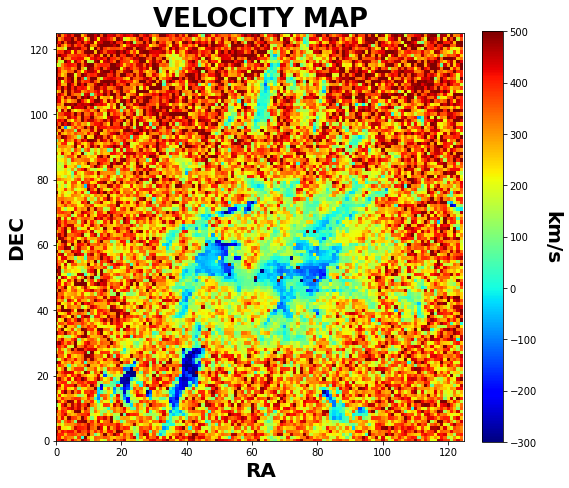

In [6]:
lplt.plot_map(vel_map, 'velocity', cube_dir, clims=[-300,500])